# Coupled, check methane and CO2 calibration

taking these emissions from RCMIP, with the calibration of FAIR's methane lifetime as from the Thornhill paper and used in Smith et al. 2024 for v1.4.0

set up everything as in 15, and see what it looks like

In [480]:
import os

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch

In [481]:
pl.rcParams['figure.figsize'] = (8.7/2.54, 8.7/2.54)
pl.rcParams['font.size'] = 7
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['ytick.direction'] = 'in'
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['xtick.major.top'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['axes.spines.top'] = True
pl.rcParams['axes.spines.bottom'] = True
pl.rcParams['figure.dpi'] = 150

In [482]:
os.makedirs('../plotsCA/', exist_ok=True)

In [483]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [484]:
natural_forcing_df = pd.read_csv('../data/calibration/natural_forcing.csv', index_col=0)

In [485]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
runs = [1, 2, 3, 4, 8]

In [486]:
temp_ukesm = np.ones((251, 4, 5)) * np.nan
for iscen, scenario in enumerate(scenarios):
    for irun, run in enumerate(runs):
        temp_ukesm[:165, iscen, irun] = pd.read_csv(f'../data/fredriksen2022/historical/UKESM1-0-LL_historical_r{run}i1p1f2_anomalies.txt', index_col=0)['tas'].values
        temp_ukesm[165:, iscen, irun] = pd.read_csv(f'../data/fredriksen2022/{scenario}/UKESM1-0-LL_{scenario}_r{run}i1p1f2_anomalies.txt', index_col=0)['tas'].values

In [487]:
f = FAIR(ch4_method="Thornhill2021")  # interactive methane lifetime

In [488]:
configs = ['UKESM1-0-LL']
species, properties = read_properties(filename='../data/species_configs_properties_vanilla.csv')
#species.remove('CO2 FFI')      # c-driven run
#species.remove('CO2 AFOLU')    # c-driven run
species.remove('Halon-1202')   # not in CMIP6 list of species
species.remove('Contrails')    # not modelled in UKESM, I think
species.remove('NOx aviation') # which renders this redundant
species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
#del properties['CO2 FFI']
#del properties['CO2 AFOLU']
del properties['Halon-1202']
del properties['Contrails']
del properties['NOx aviation']
del properties['Light absorbing particles on snow and ice']
for specie in species:
    if properties[specie]['greenhouse_gas']:
        if specie=='CH4':
            properties[specie]['input_mode'] = 'emissions'
        elif specie=='CO2':
            properties[specie]['input_mode'] = 'calculated'
        else:
            properties[specie]['input_mode'] = 'concentration'
properties['Land use']['input_mode'] = 'forcing'

In [489]:
f.define_time(1850, 2101, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)

In [490]:
f.allocate()

In [491]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [492]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [493]:
f.fill_species_configs(filename='../data/species_configs_properties_vanilla.csv')

In [494]:
f.fill_from_rcmip()

In [495]:
# should we set AFOLU emissions to zero which are not part of the esm-driven runs?
# here I do not, since fair is already biased low relative to UKESM in the future (but not in the present)
# f.emissions.loc[dict(specie='CO2 AFOLU')] = 0

In [496]:


colors=['#000000',"#0A4C8F", "#5C0A5C", '#99004d','#009933','#00e64d','#00cc66','#e60000','#e6e600','#0099cc','#007399','#0080ff','#b300b3',"#a02feb",'#ff661a',"#e9c061",'#ff9966','#ff99ff','#ff6699','#cc6699']
        
         #'#996633', '#cc3300','#336600', '#0066cc','#cc00ff', '#ff9900','#00cc99',   ]

In [497]:
'SSP2-45' '#000000', 
'SSP2-45_TFmethane3', '#004080'
'SSP2-45_TF_BC_2', '#660066'
'SSP2-45_CO2_land2',  '#99004d'
'SSP2-45-119_FFI',  '#996633'
'SSP2-45_techCO2_neg17', '#009933'
'SSP2-45_techCO2_neg10', '#00e64d'
'SSP2-45_techCO2_neg5', '#00cc66'
'SSP1-19', '#e6e600'
'SSP2-45_CO2land4', '#e60000'
'SSP2-45_TF3_CO2neg17','#0099cc'
'SSP2-45_TF3_CO2neg10','#007399'
'SSP2-45_TF3_CO2neg5','#0080ff'
'SSP2-45_TF_BC2_land2','#b300b3'

'SSP2-45_TF3_CO2neg17_land2','#e64d00'
'SSP2-45_TF3_CO2neg10_land2','#ff661a'
'SSP2-45_TF3_CO2neg5_land2', '#ff9966'

'SSP2-45_TF_BC2_CO2neg17_land4' '#ff33ff'
'SSP2-45_TF_BC2_CO2neg10_land4','#ff99ff'
'SSP2-45_TF_BC2_CO2neg5_land4' '#ff6699'

'SSP2-45_TF_BC2_CO2neg5_land4#ff6699'

In [ ]:
emissions_scenarios = pd.read_csv('../../september25_runs/AR6_emissions/all_scenarios_MtCO2.csv')
#print(emissions_scenarios)\
wantedco2ffi=emissions_scenarios[emissions_scenarios['variable']=='CO2 FFI']#
print(wantedco2ffi)
#print(emissions_scenarios.index)

row=270
color_row= '#009933'
label_row='SSP2-45_techCO2_neg17'

wanted_scenarioco2ffi=emissions_scenarios.loc[row]
#print(tmp)

print(wanted_scenarioco2ffi)

tmpco2ffi=np.array(wanted_scenarioco2ffi[258:])
print(tmpco2ffi.shape)

#tmp=np.swapaxes(tmp)
print(tmpco2ffi.shape)


print(tmpco2ffi.shape)
tmpco2ffi=tmpco2ffi.reshape(97,1)
print(tmpco2ffi.shape)
f.emissions.loc[dict(specie='CO2 FFI',scenario='ssp245')][154:]=tmpco2ffi/1000

                          scenario region variable       Unit   1750.5  \
0                          SSP2-45  World  CO2 FFI  Mt CO2/yr  9.50562   
54              SSP2-45_TFmethane3  World  CO2 FFI  Mt CO2/yr  9.50562   
108                SSP2-45_TF_BC_2  World  CO2 FFI  Mt CO2/yr  9.50562   
162              SSP2-45_CO2_land2  World  CO2 FFI  Mt CO2/yr  9.50562   
216               SSP2-45_CO2land4  World  CO2 FFI  Mt CO2/yr  9.50562   
270          SSP2-45_techCO2_neg17  World  CO2 FFI  Mt CO2/yr  9.50562   
324          SSP2-45_techCO2_neg10  World  CO2 FFI  Mt CO2/yr  9.50562   
378           SSP2-45_techCO2_neg5  World  CO2 FFI  Mt CO2/yr  9.50562   
432           SSP2-45_TF3_CO2neg17  World  CO2 FFI  Mt CO2/yr  9.50562   
486           SSP2-45_TF3_CO2neg10  World  CO2 FFI  Mt CO2/yr  9.50562   
540            SSP2-45_TF3_CO2neg5  World  CO2 FFI  Mt CO2/yr  9.50562   
594           SSP2-45_TF_BC2_land2  World  CO2 FFI  Mt CO2/yr  9.50562   
648     SSP2-45_TF3_CO2neg17_land2  Wo

In [499]:
emissions_scenarios = pd.read_csv('../../september25_runs/AR6_emissions/all_scenarios_MtCO2.csv')
#print(emissions_scenarios)\
wantedco2afolu=emissions_scenarios[emissions_scenarios['variable']=='CO2 FFI']#
#print(wanted)
#print(emissions_scenarios.index)

wanted_scenarioco2afolu=emissions_scenarios.loc[row+1]


print(wanted_scenarioco2afolu)

tmpco2afolu=np.array(wanted_scenarioco2afolu[258:])

tmpco2afolu=tmpco2afolu.reshape(97,1)
print(tmpco2afolu.shape)
f.emissions.loc[dict(specie='CO2 AFOLU',scenario='ssp245')][154:]=tmpco2afolu/1000

scenario    SSP2-45_CO2land4
region                 World
variable           CO2 AFOLU
Unit               Mt CO2/yr
1750.5            297.464607
                  ...       
2096.5         -10499.228844
2097.5         -10678.192972
2098.5           -10857.1571
2099.5         -11036.121228
2100.5         -11215.085356
Name: 217, Length: 355, dtype: object
(97, 1)


In [500]:
emissions_scenarios = pd.read_csv('../../september25_runs/AR6_emissions/all_scenarios_MtCO2.csv')
#print(emissions_scenarios)\
wantedco2ch4=emissions_scenarios[emissions_scenarios['variable']=='CO2 FFI']#
#print(wanted)
#print(emissions_scenarios.index)

wanted_scenarioch4=emissions_scenarios.loc[row+3]


print(wanted_scenarioch4)

tmpch4=np.array(wanted_scenarioch4[258:])

tmpch4=tmpch4.reshape(97,1)
print(tmpch4.shape)
f.emissions.loc[dict(specie='CH4',scenario='ssp245')][154:]=tmpch4

scenario    SSP2-45_CO2land4
region                 World
variable                 CH4
Unit               Mt CH4/yr
1750.5             19.019783
                  ...       
2096.5            296.618292
2097.5            296.251953
2098.5            295.885614
2099.5            295.519275
2100.5            295.519275
Name: 219, Length: 355, dtype: object
(97, 1)


In [501]:
"""
for iscen, scenario in enumerate(scenarios):
    pl.plot(f.emissions.loc[dict(specie='CO2 FFI', scenario=scenario)], label=scenario)
pl.legend()
for iscen, scenario in enumerate(scenarios):
    pl.plot(f.emissions.loc[dict(specie='CO2 AFOLU', scenario=scenario)], label=scenario)
    #pl.plot(f.emissions.loc[dict(specie='CO2 FFI', scenario=scenario)], label=scenario)
pl.legend()
for iscen, scenario in enumerate(scenarios):
    pl.plot(f.emissions.loc[dict(specie='CH4', scenario=scenario)], label=scenario)
    #pl.plot(f.emissions.loc[dict(specie='CO2 FFI', scenario=scenario)], label=scenario)
pl.legend()
"""

"\nfor iscen, scenario in enumerate(scenarios):\n    pl.plot(f.emissions.loc[dict(specie='CO2 FFI', scenario=scenario)], label=scenario)\npl.legend()\nfor iscen, scenario in enumerate(scenarios):\n    pl.plot(f.emissions.loc[dict(specie='CO2 AFOLU', scenario=scenario)], label=scenario)\n    #pl.plot(f.emissions.loc[dict(specie='CO2 FFI', scenario=scenario)], label=scenario)\npl.legend()\nfor iscen, scenario in enumerate(scenarios):\n    pl.plot(f.emissions.loc[dict(specie='CH4', scenario=scenario)], label=scenario)\n    #pl.plot(f.emissions.loc[dict(specie='CO2 FFI', scenario=scenario)], label=scenario)\npl.legend()\n"

In [502]:
landuse_erf = pd.read_csv('../data/calibration/landuse_forcing.csv', index_col=0)
f.forcing.loc[dict(specie='Land use')] = landuse_erf.values[:, :, None]

In [503]:
# 1850 baselines
# CH4 emissions driven in this one
for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3', 'CH4']:
    f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[dict(specie=specie, timepoints=1850.5, scenario='ssp245')]

f.concentration.loc[dict(specie="CO2", timebounds=1850)] = 284.26199849
f.concentration.loc[dict(specie="CH4", timebounds=1850)] = 808.23201497
f.concentration.loc[dict(specie="Equivalent effective stratospheric chlorine", timebounds=1850)] = 344.36275911

for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
    'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'Equivalent effective stratospheric chlorine']:
    f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[dict(specie=specie, timebounds=1850, scenario='ssp245')]

f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 344.36275911
f.species_configs['baseline_concentration'].loc[dict(specie='CH4')] = 808.23201497
f.concentration.loc[dict(specie="CH4", timebounds=1850)] = 808.23201497

## rebase volcanic to zero mean
#f.forcing.loc[dict(specie='Volcanic')] = f.forcing.loc[dict(specie='Volcanic')] - f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')].mean()

# override RCMIP natural forcing
fill(f.forcing, np.array(natural_forcing_df.loc[1850:2101, 'solar'])[:, None, None], specie='Solar')
fill(f.forcing, np.array(natural_forcing_df.loc[1850:2101, 'volcanic'])[:, None, None], specie='Volcanic')

In [504]:
ods = ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
        'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402']

hfc = ['CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
        'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
        'HFC-365mfc', 'HFC-4310mee']

In [505]:
# UKESM specific ESM component calibrations: DO NOT MODIFY
#f.species_configs['land_use_cumulative_emissions_to_forcing'].loc[dict(specie="CO2 AFOLU")] = -0.0003024895261521421
f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = -0.00029119797470220245
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = 0.0007481397748679878
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = 0.0006596999582126578
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = 0.000984642055228785
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = -0.09693932216231645
f.species_configs['forcing_scale'].loc[dict(specie="N2O")] = 1.16044956348451
f.species_configs['forcing_scale'].loc[dict(specie="CO2")] = 1.04321901751203

for specie in species:
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie=specie)] = 0
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00283793
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.01757433
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.0028512
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='CH4')] = -5.09377882e-05
f.species_configs['aci_scale'].loc[:] = -8.22336280e-01
# f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -8.22336281e-01
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 3.01888722e-02
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 5.07111186e-30
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 6.60381587e-16
f.species_configs['aci_shape'].loc[dict(specie="CH4")] = -2.61186114e-04

for specie in ods:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 1.44336634
for specie in hfc:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 0.25250486
    
# This bit pertains to the methane lifetime
# UKESM-specific values
# Thornhill et al. 2021a, 2021b
f.species_configs['ch4_lifetime_chemical_sensitivity'].loc[dict(specie="CH4")] = +0.22/1023.2219696044921
f.species_configs['ch4_lifetime_chemical_sensitivity'].loc[dict(specie="NOx")] = -0.25/142.18364862292066
f.species_configs['ch4_lifetime_chemical_sensitivity'].loc[dict(specie="VOC")] = +0.11/166.74246925530488
f.species_configs['ch4_lifetime_chemical_sensitivity'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = -0.049/1133.249639460932
f.species_configs['ch4_lifetime_chemical_sensitivity'].loc[dict(specie="N2O")] = -0.012/53.96694437662762
f.species_configs['lifetime_temperature_sensitivity'][:] = -0.0408
f.species_configs['unperturbed_lifetime'].loc[dict(specie="CH4")] = 8

# This bit pertains to carbon cycle feedbacks
# UKESM specific values from 1pctCO2 experiments in Leach et al. 2021
f.species_configs['iirf_0'].loc[dict(specie="CO2")] = 37.91594456570033
f.species_configs['iirf_airborne'].loc[dict(specie="CO2")] = 0.0018119017134572424/3.664
f.species_configs['iirf_uptake'].loc[dict(specie="CO2")] = 0.020138272127751655/3.664
f.species_configs['iirf_temperature'].loc[dict(specie="CO2")] = 2.6714005898495543

In [506]:
#f.species_configs.sel(specie='CH4')

In [507]:
#f.concentration.loc[dict(timebounds=1850, scenario='ssp245')]

In [508]:
f.run()

Running 4 projections in parallel:   0%|          | 0/251 [00:00<?, ?timesteps/s]

Running 4 projections in parallel: 100%|██████████| 251/251 [00:00<00:00, 2672.46timesteps/s]


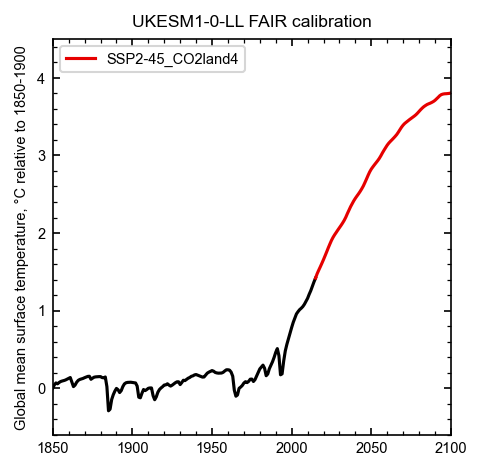

In [509]:
colors = ['#003466', '#f69320', '#df0000', '#980002']
pl.plot(np.arange(1850, 2016), f.temperature[:166, 0, 0, 0], color='k')
for ens in range(5):
    pl.plot(np.arange(1850.5, 2015), temp_ukesm[:165, 0, ens], lw=0.5, color='k', alpha=0)
for iscen, scenario in enumerate(scenarios):
    if scenario=='ssp245':
        pl.plot(np.arange(2015, 2102), f.temperature[165:, iscen, 0, 0], color=color_row,label=label_row)
    for ens in range(5):
        if scenario=='ssp245':
            pl.plot(np.arange(2015.5, 2101), temp_ukesm[165:, iscen, ens], lw=0.5, color=colors[iscen], alpha=0)
#pl.text(1860, 1.5, 'Thick lines: FAIR emulation', fontweight='bold')
#pl.text(1860, 1.3, 'Thin lines: UKESM output')
pl.title('UKESM1-0-LL FAIR calibration')
pl.ylim(-0.6,4.5)
pl.xlim(1850, 2100)
pl.legend(loc='upper left')
pl.ylabel('Global mean surface temperature, °C relative to 1850-1900')

pl.savefig('../plotsCA/emissions_driven_methane_co2'+str(label_row)+'.png', transparent=True)


Text(0.5, 1.0, 'Effective radiative forcing in FAIR calibration')

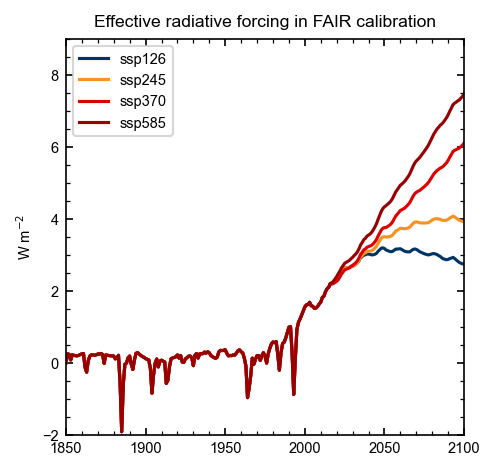

In [510]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2102), f.forcing_sum[:, iscen, :], color=colors[iscen], label=scenario)
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(-2, 9)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing in FAIR calibration')

Text(0.5, 1.0, 'Methane concentration in FAIR calibration')

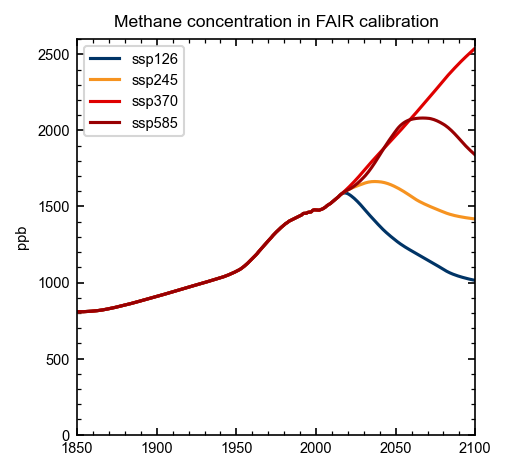

In [511]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2102), f.concentration.sel(scenario=scenario, specie="CH4"), color=colors[iscen], label=scenario)
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(0, 2600)
pl.ylabel('ppb')
pl.title('Methane concentration in FAIR calibration')

Text(0.5, 1.0, 'CO2 concentration in FAIR calibration')

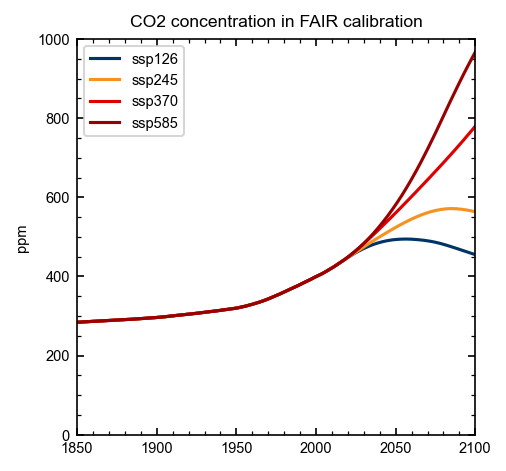

In [512]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2102), f.concentration.sel(scenario=scenario, specie="CO2"), color=colors[iscen], label=scenario)
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(0, 1000)
pl.ylabel('ppm')
pl.title('CO2 concentration in FAIR calibration')

Text(0.5, 1.0, 'Methane ERF in FAIR calibration')

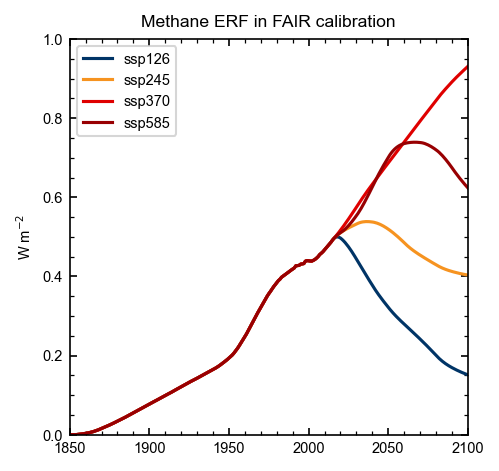

In [513]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2102), f.forcing.sel(scenario=scenario, specie="CH4"), color=colors[iscen], label=scenario)
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(0, 1)
pl.ylabel('W m$^{-2}$')
pl.title('Methane ERF in FAIR calibration')

Text(0.5, 1.0, 'CO2 ERF in FAIR calibration')

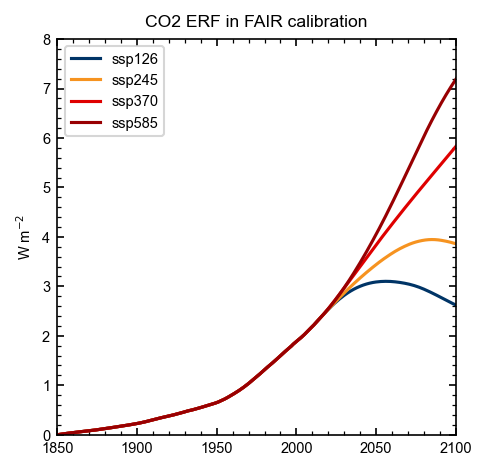

In [514]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2102), f.forcing.sel(scenario=scenario, specie="CO2"), color=colors[iscen], label=scenario)
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(0, 8)
pl.ylabel('W m$^{-2}$')
pl.title('CO2 ERF in FAIR calibration')

In [515]:
f.concentration.sel(scenario="ssp245", specie="CO2", timebounds=2015)

<xarray.DataArray (config: 1)> Size: 8B
array([434.70979165])
Coordinates:
    timebounds  float64 8B 2.015e+03
    scenario    <U6 24B 'ssp245'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'CO2'